In [1]:
import pandas as pd
import requests
import re
from tqdm import tqdm
import sys

In [2]:
def create_url(baseurl, params):
    return baseurl + "&".join([f"{x}={y}" for x, y in params.items()])

In [4]:
baseurl = " https://zelda.fandom.com/api.php?"
params = {
    "action": "query",
    "format": "json",
    "prop": "revisions",
    "rvslots": "*",
    "rvprop": "content",
    "indexpageids": True
    }
titles = [
    "Characters_in_Breath_of_the_Wild", 
    "Enemies_in_Breath_of_the_Wild", 
    "Bosses_in_Breath_of_the_Wild"
    ]

In [5]:
# Extracting all links of format {{Term|BoTW|(here)|link}}

extraction = []
for title in titles:
    new_params = params
    new_params["titles"] = title
    url = create_url(baseurl, new_params)
    
    data = requests.get(url).json()
    pid = data["query"]["pageids"][0]
    text = data["query"]["pages"][pid]["revisions"][0]["slots"]["main"]["*"]
    
    if "==Traps==" in text:
        text = text.split("==Traps==")[0]

    extraction.extend([x[0] for x in expr.findall(text)])

In [6]:
# Sorting the extractions after whether they are traps, places, or characters.
# First two gets removed

Chars = []

for e in tqdm(extraction):
    new_params = params
    new_params["titles"] = e + "%23Breath_of_the_Wild"
    url = create_url(baseurl, new_params)

    data = requests.get(url).json()
    pid = data["query"]["pageids"][0]
    text = data["query"]["pages"][pid]["revisions"][0]["slots"]["main"]["*"]
    
    if "Infobox Place" in text:
        continue
    
    with open(f"txts/{e}.txt", "w") as f:
        f.write(str(text.encode(encoding="utf-8", errors="xmlcharrefreplace")))
        
    if "Infobox Boss" in text:
        Chars.append([e, "Boss"])
    elif "Infobox Character" in text:
        Chars.append([e, "Ally"])
    elif "Infobox Enemy" in text:
        Chars.append([e, "Enemey"])
    elif "Infobox Animal" in text:
        Chars.append([e, "Animal"])
    else:
        Chars.append([e, "Unknown"])
    


In [7]:
df = pd.DataFrame(Chars)
df = df[df.Role != "Unknown"]
df.to_csv("ZeldaBotw.csv")

NameError: name 'Chars' is not defined

In [8]:
df = pd.read_csv("ZeldaBotw.csv")

In [9]:
gender_expr = re.compile(r"gender ?= ?(\w*)")
race_expr = re.compile(r"(?:race|species) ?= ?(?:\[\[(.*?)\]\]|(?:\{\{Term\|Series\|Human\|link\}\}<br>)?\{\{Term\|BotW\|(.*?)(?:\|link)?\}\}|(?:\n)?)")

genders = []
races = []

for i, name in enumerate(df.Name):
    text = open(f"txts/{name}.txt", "r").read()
    gender = gender_expr.findall(text)
    gender = gender[0] if len(gender) > 0 else "Unknown"
    genders.append(gender)

    race = race_expr.findall(text)
    if len(race) == 0:
        race = "Unknown"
    else:
        race = race[0][0] if len(race[0][0]) > len(race[0][1]) else race[0][1]
    races.append(race)

In [10]:
df["Race"] = races
df["Gender"] = genders
df.drop("Unnamed: 0", axis=1, inplace=True)
print(df)

                  Name  Role     Race  Gender
0               Baddek  Ally   Hylian    Male
1               Bamboo  Ally    Horse        
2                Banji  Ally   Hylian  Female
3               Baumar  Ally   Hylian    Male
4                Bayge  Ally    Goron    Male
..                 ...   ...      ...     ...
570  Waterblight Ganon  Boss                 
571       Master Kohga  Boss  Sheikah    Male
572    Monk Maz Koshia  Boss  Sheikah    Male
573     Calamity Ganon  Boss             Male
574   Dark Beast Ganon  Boss             Male

[575 rows x 4 columns]


In [11]:
import networkx as nx

G = nx.DiGraph()
for _, (name, role, race, gender) in df.iterrows():
    G.add_node(name, role=role, race=race, gender=gender)

In [12]:
# Regex expressions
dir_link = re.compile(r"\[\[(.*?)(?:\|.*?)?\]\]")
cur_link = re.compile(r"\{\{(?:Term|Plural)\|BotW\|(.*?)(?:\|.*?)?(?:Link?)\}\}")
quick_link = re.compile(r"\[\[(.*?)(?:\|.*?)?(?:\|#Breath of the Wild)?\]\]")

for name in df.Name:
    description = open(f"./txts/{name}.txt", "r").read()
    links = []
    links.extend(dir_link.findall(description))
    links.extend(cur_link.findall(description))
    for link in links:
        if link in df.Name.values and link != name:
            G.add_edge(name, link)

In [13]:
# nx.draw(G, node_size=10)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

for node in list(G.nodes()):
    if G.degree(node) == 0:
        G.remove_node(node)

Number of nodes: 394
Number of links/edges: 861


<AxesSubplot:title={'center':'Role'}>

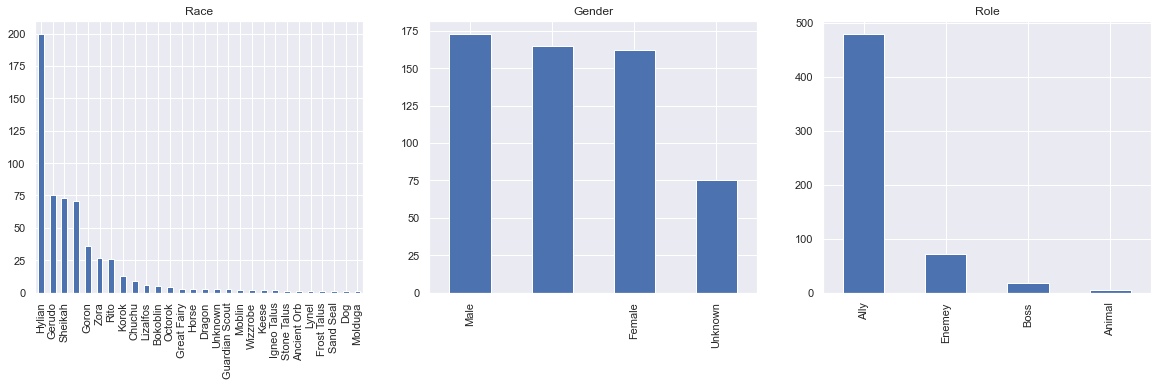

In [14]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of links/edges: {G.number_of_edges()}")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

df.Race.value_counts().plot.bar(ax=ax1, title="Race")
df.Gender.value_counts().plot.bar(ax=ax2, title="Gender")
df.Role.value_counts().plot.bar(ax=ax3, title="Role")

In [ ]:
print(f"Highest connected character: {max(G.degree(), key=lambda x: x[1])}")

Highest connected character: ('Link', 181)
